## Extracting and Saving Primary Neutrino Energy Data

This section processes Monte Carlo (MC) simulated neutrino interaction data to extract **primary neutrino energy values** and save them as a structured dataset.

### **Process Overview:**
1. **Reading the ROOT File**:
   - The dataset is loaded using `km3io.OfflineReader`, which accesses MC simulation data.

2. **Filtering Primary Neutrino Tracks**:
   - The condition `status == 100` selects only **primary neutrino tracks**, ensuring that secondary particles are excluded.
   - The energy values (`E`) of these primary neutrinos are extracted.

3. **Flattening the Data**:
   - `awkward.flatten()` is applied to handle nested structures and create a **1D array** of energy values.

4. **Creating a Pandas DataFrame**:
   - The extracted energy values are stored in a structured format for easier analysis.

5. **Saving as CSV**:
   - The final dataset is exported as `"Primary_Neutrino_Energy.csv"`, allowing for **external processing, model training, and visualization**.

### **Purpose:**
- Provides a **cleaned dataset** of true neutrino energy values from MC simulations.
- Enables direct comparison with **reconstructed energy values** from machine learning models.
- Saves the extracted energy values in a structured format for **further statistical analysis**.

In [1144]:
import pandas as pd
import awkward as ak
import km3io as ki

r = ki.OfflineReader('/Users/meskara/Documents/Energy_Reconstruction/mcv6.4.gsg_nue-NCHEDIS_1e2-1e8GeV.sirene.jterbr00009985.jchain.aanet.253.root')

primary_neutrino_energy = ak.flatten(r[r.mc_tracks.status == 100].mc_tracks.E, axis=1)

df_energy = pd.DataFrame({'Energy': primary_neutrino_energy})

df_energy.to_csv('Primary_Neutrino_Energy.csv', index=False)

print("Filtered energy data saved to 'Primary_Neutrino_Energy.csv'")

Filtered energy data saved to 'Primary_Neutrino_Energy.csv'


## Importing Necessary Libraries

This section imports essential libraries for **data analysis, visualization, and machine learning**.

### **Data Handling and Visualization:**
- `pandas`: Used for loading and manipulating structured data.
- `matplotlib.pyplot`: Provides functions for data visualization.
- `numpy`: Enables numerical computations and array manipulations.
- `seaborn`: Enhances visualization aesthetics and statistical analysis.

### **Machine Learning Models:**
- `RandomForestRegressor`, `GradientBoostingRegressor`, `HistGradientBoostingRegressor`: 
  - **Ensemble learning models** based on decision trees.
  - Used for regression tasks to model complex relationships.
- `KNeighborsRegressor`: A **non-parametric** algorithm predicting values based on the nearest neighbors.

### **Model Training and Evaluation:**
- `train_test_split`: Splits the dataset into training and testing subsets.
- `mean_absolute_error`, `mean_squared_error`, `r2_score`: Metrics for evaluating regression model performance.
- `StandardScaler`: Standardizes input features to improve model training efficiency.

### **Deep Learning (Neural Networks) with TensorFlow/Keras:**
- `Sequential`: Defines a **feedforward neural network** architecture.
- `Dense`, `Dropout`: Fully connected layers and dropout regularization.
- `Conv1D`, `Flatten`: Convolutional and flattening layers for feature extraction.
- `Adam`: An optimizer that adjusts learning rates adaptively.

### **Purpose:**
These imports facilitate a **comprehensive machine learning workflow**, including:
- **Preprocessing**: Standardization of features.
- **Model Training**: Comparing tree-based models, k-NN, and deep learning approaches.
- **Evaluation**: Measuring model accuracy using standard regression metrics.
- **Visualization**: Graphically analyzing results and model performance.

This setup enables an **end-to-end analysis pipeline** for energy reconstruction.

In [1145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

## Loading and Preparing Data

This section loads two datasets from CSV files and ensures they are properly structured for further analysis.

### **Datasets:**
1. **Truth Data (`df_truth`)**:
   - Contains detailed information about simulated neutrino interactions.
   - Loaded from `"All_fields_in_one_file.csv"`.
  
2. **Reconstructed Data (`df_reco`)**:
   - Contains the extracted primary neutrino energy values.
   - Loaded from `"Primary_Neutrino_Energy.csv"`.

### **Preprocessing Steps:**
- **Resetting Index**: 
  - Ensures that both datasets have a **continuous index** after loading.
  - Avoids potential inconsistencies in indexing that could affect merging or alignment.

### **Purpose:**
- This step prepares the datasets for **feature extraction, model training, and comparison between true and reconstructed energy values**.
- Ensuring proper alignment of indices is crucial for accurate model input and evaluation.

In [1146]:
df_truth = pd.read_csv("/Documents/Energy_Reconstruction/All_fields_in_one_file.csv")
df_reco = pd.read_csv("/Documents/Energy_Reconstruction/Primary_Neutrino_Energy.csv")

df_truth = df_truth.reset_index(drop=True)
df_reco = df_reco.reset_index(drop=True)

## Selecting Features and Target Variable

This section extracts relevant features (`X`) and the target variable (`y`) from the loaded datasets.

### **Feature Selection (`X`)**:
The selected features from `df_truth` include:
- **Temporal Information**: `t`, `tdc` (time-related features).
- **Spatial Coordinates**: `pos_x`, `pos_y`, `pos_z` (position in the detector).
- **Directionality**: `dir_x`, `dir_y`, `dir_z` (directional components).
- **Signal Properties**: `tot` (time-over-threshold), `a` (a dataset parameter).
- **Trigger Information**: `trig` (indicates event registration).

> **Note**: Features such as `id`, `id_channel`, and `id_dim` are excluded since they are identifiers and may not contribute to the prediction.

### **Target Variable (`y`)**:
- The **primary neutrino energy** is extracted from `df_reco['Energy']`.
- Since energy spans multiple orders of magnitude, a **logarithmic transformation** is applied:

&&
y_{\text{log}} = \log_{10}(y)
&&

### **Purpose**:
- Feature selection ensures the model receives relevant inputs for energy reconstruction.
- The logarithmic transformation stabilizes variance and helps the model generalize across different energy scales.

In [1147]:
X = df_truth[['channel_id', 'dom_id','t', 'tdc', 'pos_x', 'pos_y', 'pos_z', 'dir_x', 'dir_y', 'dir_z', 'tot', 'a', 'trig']]  # Features without id, id channel, id dim
y = df_reco['Energy']  
y_log = np.log10(y)  

## Standardizing Features

To ensure that all features contribute equally to the model, **feature standardization** is applied using `StandardScaler`.

### **Why Standardize?**
1. **Removes Scale Differences**: Features such as position (`pos_x`, `pos_y`, `pos_z`) and time (`t`, `tdc`) have different units and magnitudes.
2. **Improves Model Performance**: Many machine learning algorithms (especially gradient-based methods) perform better when features are standardized.
3. **Reduces Sensitivity to Outliers**: Standardization mitigates the impact of extreme values.

### **Standardization Formula:**
$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$
where:
- $\mu$ is the mean of each feature.
- $\sigma$ is the standard deviation.

### **Implementation:**
- `StandardScaler().fit_transform(X)` computes the mean and standard deviation for each feature and scales the data accordingly.

### **Purpose:**
- Ensures **consistent feature scaling**, improving model efficiency and training stability.

In [1148]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1149]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

## Reverting Log Transformation of the Target Variable

Since we applied a **logarithmic transformation** to the energy values earlier:

$$
y_{\text{log}} = \log_{10}(y)
$$

we now reverse this transformation to obtain the **original energy values**:

$$
y_{\text{test original}} = 10^{y_{\text{test log}}}
$$

### **Why Revert the Log Transformation?**
1. **Interpretability**: The model predicts `log10(E)`, but we need actual energy values for meaningful evaluation.
2. **Comparison with True Values**: Regression performance metrics like MAE and MSE must be calculated using original-scale energy values.
3. **Post-processing for Analysis**: If results are used in scientific applications or visualizations, they must be in their original physical units.

### **Purpose:**
This step ensures that model predictions and true energy values are in the **same scale**, allowing accurate performance evaluation.

In [1150]:
y_test_original = 10 ** y_test_log

## Training a Histogram-Based Gradient Boosting Regressor

This section trains a **HistGradientBoostingRegressor**, an optimized gradient boosting model designed for efficiency and performance in large datasets.

### **Model Characteristics:**
- **Histogram-Based Algorithm**:
  - Unlike traditional gradient boosting, this model **bins continuous feature values** into discrete bins, significantly speeding up computation.

### **Hyperparameters Used:**
- **Regularization (`l2_regularization=0.8`)**:
  - Prevents overfitting by penalizing overly complex models.
- **Learning Rate (`learning_rate=0.01`)**:
  - Controls how much each tree contributes to the final prediction.
  - A **low learning rate** improves generalization at the cost of longer training time.
- **Tree Structure:**
  - `max_bins=255`: Limits the number of bins used for feature quantization, optimizing memory and performance.
  - `max_depth=7`: Restricts the depth of each tree to **prevent excessive complexity**.
  - `max_iter=3000`: Trains the model with **3000 boosting iterations** for high accuracy.
  - `max_leaf_nodes=10`: Limits the number of leaf nodes per tree, balancing complexity and generalization.
  - `min_samples_leaf=20`: Ensures each leaf contains at least **20 samples**, preventing overly specific rules.

### **Loss Function (`loss='squared_error'`)**:
- Uses the **mean squared error (MSE)** as the loss function, making it suitable for **continuous target values**.

### **Reproducibility (`random_state=42`)**:
- Ensures that results are consistent across different runs.

### **Purpose:**
- This gradient boosting model is designed to **efficiently handle large datasets** while maintaining high predictive accuracy.
- The carefully chosen hyperparameters aim to balance **bias-variance tradeoff**, improving generalization to unseen data.

In [1151]:
model = HistGradientBoostingRegressor( l2_regularization = 0.8, learning_rate = 0.01, max_bins = 255, max_depth = 7, max_iter = 3000, max_leaf_nodes = 10, min_samples_leaf = 20, loss='squared_error', random_state=42).fit(X_train, y_train_log)

## Evaluating Model Performance on Training Data

This command calculates the **R² score (coefficient of determination)** for the trained **HistGradientBoostingRegressor** model on the training dataset.

### **What is the R² Score?**
$$
R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
$$

- Measures how well the model explains the variance in the training data.
- A score of **1.0** indicates a perfect fit (low bias).
- A score of **0.0** means the model is no better than predicting the mean of the target variable.
- Negative values indicate the model performs worse than a simple mean predictor.

### **Purpose:**
- This score provides insight into how well the model has **learned patterns from the training data**.
- A very high R² on training data may indicate **overfitting**, requiring further validation on test data.
- Comparing R² on both training and test sets helps assess **generalization performance**.

In [1152]:
model.score(X_train,y_train_log)

0.8749037953549657

In [1153]:
y_pred_log = model.predict(X_test)

## Reverting Log Transformation of Predictions

Since the model was trained to predict **log-transformed energy values**:

$$
y_{\text{log}} = \log_{10}(y)
$$

we now **reverse** this transformation to recover the predicted energy values in their original scale:

$$
y_{\text{pred}} = 10^{y_{\text{pred log}}}
$$

### **Why Revert the Log Transformation?**
1. **Interpretability**: The model outputs logarithmic energy values, but real-world applications require actual energy values.
2. **Consistency with True Values**: To compare predictions with the original energy data, they must be in the same scale.
3. **Meaningful Evaluation**: Performance metrics like **MAE, MSE, and R²** must be computed using the original energy scale.

### **Purpose:**
This step ensures that model predictions are **properly scaled for evaluation** and real-world interpretation.

In [1154]:
y_pred = 10 ** y_pred_log

In [1156]:
BINS = np.logspace(1,9,50)

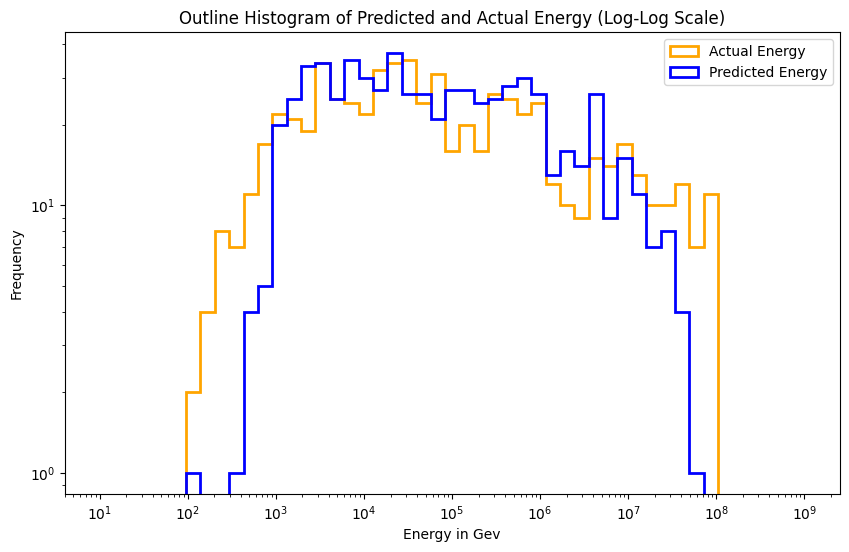

In [1157]:
plt.figure(figsize=(10, 6))

plt.hist(y_test_original, bins=BINS, histtype='step', color='orange', linewidth=2, label='Actual Energy')
plt.hist(y_pred, bins=BINS, histtype='step', color='blue', linewidth=2, label='Predicted Energy')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy in Gev')
plt.ylabel('Frequency')
plt.title('Outline Histogram of Predicted and Actual Energy (Log-Log Scale)')

plt.legend()

plt.show()